# Connect to Hive

In [ ]:
from pyspark.sql import SparkSession

# Add here your team number teamx
team = "team9"

# location of your Hive database in HDFS
warehouse = "project/hive/warehouse"

spark = SparkSession.builder\
        .appName("{} - spark ML".format(team))\
        .master("yarn")\
        .config("hive.metastore.uris", "thrift://hadoop-02.uni.innopolis.ru:9883")\
        .config("spark.sql.warehouse.dir", warehouse)\
        .config("spark.sql.avro.compression.codec", "snappy")\
        .enableHiveSupport()\
        .getOrCreate()

sc = spark.sparkContext

In [ ]:
spark.sql("SHOW DATABASES").show()
spark.sql("USE team9_projectdb").show()
spark.sql("SHOW TABLES").show()
spark.sql("SELECT * FROM team9_projectdb.ctr_part").show()

In [ ]:
spark

# list Hive databases

In [4]:
print(spark.catalog.listDatabases())
spark.sql("SHOW DATABASES;").show()

[Database(name='default', description='Default Hive database', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/apps/hive/warehouse'), Database(name='root_db', description='', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/user/root/root_db'), Database(name='team0_projectdb', description='', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/user/team0/project/hive/warehouse'), Database(name='team12_hive_projectdb', description='', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/user/team12/project/hive/warehouse'), Database(name='team13_projectdb', description='', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/user/team13/project/hive/warehouse'), Database(name='team14_projectdb', description='', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/user/team14/project/hive/warehouse'), Database(name='team15_projectdb', description='', locationUri='hdfs://hadoop-02.uni.innopolis.ru:8020/user/team15/project/hive/warehouse'), Database(name='team16_projectdb', description

In [5]:
print(spark.catalog.listTables("team9_projectdb"))

[Table(name='ctr_part', database='team9_projectdb', description=None, tableType='EXTERNAL', isTemporary=False)]


In [6]:
ctr = spark.read.format("avro").table('team9_projectdb.ctr_part')
ctr

DataFrame[session_id: int, datetime: timestamp, user_id: int, campaign_id: int, webpage_id: int, product_category_1: int, product_category_2: float, user_group_id: float, gender: string, age_level: float, user_depth: float, city_development_index: float, var_1: int, is_click: int, product: string]

In [7]:
ctr.printSchema()

spark.sql("SELECT * FROM ctr_part WHERE user_id=287005").show()

spark.sql("SELECT AVG(product_category_1) FROM ctr_part;").show()

# spark.sql("SELECT * from ctr_part where product_category_2 is NULL;").show()

root
 |-- session_id: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- webpage_id: integer (nullable = true)
 |-- product_category_1: integer (nullable = true)
 |-- product_category_2: float (nullable = true)
 |-- user_group_id: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- age_level: float (nullable = true)
 |-- user_depth: float (nullable = true)
 |-- city_development_index: float (nullable = true)
 |-- var_1: integer (nullable = true)
 |-- is_click: integer (nullable = true)
 |-- product: string (nullable = true)

+----------+-------------------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+
|session_id|           datetime|user_id|campaign_id|webpage_id|product_category_1|product_category_2|user_group_id|gender|age_level|user_depth|city_developme

# Specify the input and output features

In [8]:
# We will use the following features
# Excluded 'product_category_2', 'city_development_index' because they have a lot of nulls
# Excuded hiredate because it is given as practice to implement the cos_sin_transformation for the student
features = ['session_id', 'DateTime', 'user_id', 'product', 'campaign_id',
       'webpage_id', 'product_category_1',
       'user_group_id', 'gender', 'age_level', 'user_depth', 'var_1']

# The output/target of our model
label = 'is_click'

# Read hive tables

In [9]:
# main = spark.read.format("avro").table('team7_projectdb.main')

# depts = spark.read.format("avro").table('team7_projectdb.departments')

In [10]:
# emps.show()

In [11]:
# depts.show()

# Feature selection

In [12]:
#тут Фирас своей херней со своими данными страдает
# import pyspark.sql.functions as F

# # Remove the quotes before and after each string in job and ename columns.
# emps = emps.withColumn("job", F.translate("job","'",""))
# emps.show()
# emps = emps.withColumn("ename", F.translate("ename","'",""))
# emps.show()

In [13]:
#тут тоже
# emps = emps.select(features + [label]).na.drop()
# emps = emps.withColumn("ename_job", F.concat(F.col('ename'), F.lit("_"), F.col('job')))
# emps = emps.withColumnRenamed("sal","label")

# emps.show()

In [14]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Word2Vec, Tokenizer, RegexTokenizer
# from pyspark.sql.functions import col

# categoricalCols = ['deptno']
# textCols = ['ename_job']
# others = ['empno', 'mgr']

In [15]:
# ctr_template = ctr 

# Feature extraction

In [16]:
import math
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql.functions import when, avg, coalesce, date_format
from pyspark.sql.functions import sin, cos

In [17]:
ctr1_temp = ctr
from pyspark.sql.functions import col
ctr1_temp = ctr1_temp.orderBy(col("DateTime"))

In [18]:
ctr1_temp.show()

+----------+-------------------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+
|session_id|           datetime|user_id|campaign_id|webpage_id|product_category_1|product_category_2|user_group_id|gender|age_level|user_depth|city_development_index|var_1|is_click|product|
+----------+-------------------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+
|    333291|2017-07-02 00:00:00| 243253|     105960|     11085|                 5|               NaN|          8.0|Female|      2.0|       2.0|                   NaN|    0|       0|      C|
|    151475|2017-07-02 00:01:00| 509591|     359520|     13787|                 2|               NaN|          1.0|  Male|      1.0|       3.0|                   NaN|    0|       0|      I|
|    175422|2017-07-02 00:03:00|  43157|     35952

играюсь с разделение даты на месяц, год, день

In [19]:
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import col
# # Convert the datetime column to date type
# ctr_template = ctr_template.withColumn("datetime", ctr_template["datetime"].cast("Date"))
# # # Split dates to year, month, day# 
# ctr_template=ctr_template.withColumn("year", year(ctr_template["datetime"]).cast('int'))
# ctr_template=ctr_template.withColumn("month", month(ctr_template["datetime"]).cast('int'))
# ctr_template=ctr_template.withColumn("day", dayofmonth(ctr_template["datetime"]).cast('int'))
# ctr_template.drop("datetime")

# ctr1_temp = ctr

# ctr1_temp = ctr1_temp.orderBy(col("datetime"))
ctr1_temp = ctr1_temp.withColumn("year", date_format("datetime", "yyyy").cast('int'))    
ctr1_temp = ctr1_temp.withColumn("month", date_format("datetime", "MM").cast('int')) 
ctr1_temp = ctr1_temp.withColumn("day", date_format("datetime", "dd").cast('int'))
ctr1_temp = ctr1_temp.withColumn("hour", date_format("datetime", "HH").cast('int'))
ctr1_temp = ctr1_temp.withColumn("minute", date_format("datetime", "mm").cast('int'))
ctr1_temp = ctr1_temp.drop("datetime")

In [20]:
ctr1_temp.select('year').distinct().count()

1

In [21]:
ctr1_temp.select('month').distinct().count()

1

In [22]:
ctr1_temp.show()

+----------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+----+-----+---+----+------+
|session_id|user_id|campaign_id|webpage_id|product_category_1|product_category_2|user_group_id|gender|age_level|user_depth|city_development_index|var_1|is_click|product|year|month|day|hour|minute|
+----------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+----+-----+---+----+------+
|    333291| 243253|     105960|     11085|                 5|               NaN|          8.0|Female|      2.0|       2.0|                   NaN|    0|       0|      C|2017|    7|  2|   0|     0|
|    151475| 509591|     359520|     13787|                 2|               NaN|          1.0|  Male|      1.0|       3.0|                   NaN|    0|       0|      I|2017|    7|  2|   0|     1|
|    490038| 80

In [23]:
# Encode cyclical month and days
#the columns 'year' and 'month' have only one distinct value. We can remove them from the database

# ctr1_temp = ctr1_temp.withColumn("month_sin", sin(2 * math.pi * ctr1_temp.month / 12))
# ctr1_temp = ctr1_temp.withColumn("month_cos", cos(2 * math.pi * ctr1_temp.month / 12))
ctr1_temp = ctr1_temp.withColumn("day_sin", sin(2 * math.pi * ctr1_temp.day / 31))
ctr1_temp = ctr1_temp.withColumn("day_cos", cos(2 * math.pi * ctr1_temp.day / 31))
ctr1_temp = ctr1_temp.drop(*["month", "day", "year"])

# Encode cyclical hours and minutes

ctr1_temp = ctr1_temp.withColumn("hour_sin", sin(2 * math.pi * ctr1_temp.hour / 24))
ctr1_temp = ctr1_temp.withColumn("hour_cos", cos(2 * math.pi * ctr1_temp.hour / 24))
ctr1_temp = ctr1_temp.withColumn("minute_sin", sin(2 * math.pi * ctr1_temp.minute / 60))
ctr1_temp = ctr1_temp.withColumn("minute_cos", cos(2 * math.pi * ctr1_temp.minute / 60))
ctr1_temp = ctr1_temp.drop(*["hour", "minute"])

In [24]:
ctr1_temp.show()

+----------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+-------------------+------------------+--------+--------+-------------------+------------------+
|session_id|user_id|campaign_id|webpage_id|product_category_1|product_category_2|user_group_id|gender|age_level|user_depth|city_development_index|var_1|is_click|product|            day_sin|           day_cos|hour_sin|hour_cos|         minute_sin|        minute_cos|
+----------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+-------------------+------------------+--------+--------+-------------------+------------------+
|    333291| 243253|     105960|     11085|                 5|               NaN|          8.0|Female|      2.0|       2.0|                   NaN|    0|       0|      C|0.39435585511331855|0.91895781162

In [25]:
ctr1_temp.printSchema()

root
 |-- session_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- webpage_id: integer (nullable = true)
 |-- product_category_1: integer (nullable = true)
 |-- product_category_2: float (nullable = true)
 |-- user_group_id: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- age_level: float (nullable = true)
 |-- user_depth: float (nullable = true)
 |-- city_development_index: float (nullable = true)
 |-- var_1: integer (nullable = true)
 |-- is_click: integer (nullable = true)
 |-- product: string (nullable = true)
 |-- day_sin: double (nullable = true)
 |-- day_cos: double (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- minute_sin: double (nullable = true)
 |-- minute_cos: double (nullable = true)



In [26]:
ctr1_temp.show()

+----------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+-------------------+------------------+--------+--------+-------------------+------------------+
|session_id|user_id|campaign_id|webpage_id|product_category_1|product_category_2|user_group_id|gender|age_level|user_depth|city_development_index|var_1|is_click|product|            day_sin|           day_cos|hour_sin|hour_cos|         minute_sin|        minute_cos|
+----------+-------+-----------+----------+------------------+------------------+-------------+------+---------+----------+----------------------+-----+--------+-------+-------------------+------------------+--------+--------+-------------------+------------------+
|    333291| 243253|     105960|     11085|                 5|               NaN|          8.0|Female|      2.0|       2.0|                   NaN|    0|       0|      C|0.39435585511331855|0.91895781162

# Feature extraction

In [27]:
# ctr1_temp = ctr1_temp.withColumn("year", date_format("datetime", "yyyy").cast('int'))    
# ctr1_temp = ctr1_temp.withColumn("month", date_format("datetime", "MM").cast('int')) 
# ctr1_temp = ctr1_temp.withColumn("day", date_format("datetime", "DD").cast('int')) 
# ctr1_temp=ctr1_temp.drop("datetime")
# ctr1_temp.show()

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Word2Vec, Tokenizer, RegexTokenizer
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import when


In [29]:
categoricalCols = ['product', 'gender']
# textCols = ['ename_job']
#fill missing values
nanCols = ['user_group_id', 'user_depth', 'age_level']

In [30]:
# Table
# Fill missing values with median
imputer_median = Imputer(
    inputCols=nanCols, outputCols=["{}_imputed".format(c) for c in nanCols]
    ).setStrategy("median")

# Add imputation cols to df
ctr1_temp = imputer_median.fit(ctr1_temp).transform(ctr1_temp)
ctr1_temp = ctr1_temp.drop(*["user_group_id", "user_depth","age_level"])

# Fill missing values with mode
# imputer_mode = Imputer(
#     inputCols=["gender"], outputCols=["gender_imputed"]).setStrategy("mode")
# # ctr1_temp.fillna("Male", subset=['gender'])

# # Add imputation cols to df
# ctr1_temp = imputer_mode.fit(ctr1_temp).transform(ctr1_temp)
# ctr1_temp = ctr1_temp.drop("gender")

# # Функция для расчета моды
# def fill_with_mode(df, column):
#     mode = df.groupBy(column).count().orderBy(col("count").desc()).collect()[0][0]
#     df = df.withColumn(column, when(col(column).isNull(), mode).otherwise(col(column)))
#     return df

# def fill_with_mode(df, column):
#     mode_value = df.groupBy(column).count().orderBy(col("count").desc()).first()[0]
#     return df.fillna({column: mode_value})

# Заполните пропущенные значения модой
# ctr1_temp = fill_with_mode(ctr1_temp, "gender")
# mode_value = ctr1_temp.groupBy("gender").count().orderBy(col("count").desc()).first()[0]
# ctr1_temp = ctr1_temp.fillna(mode_value, "gender")


# Замена пустых значений (например, пустых строк) на указанное значение
ctr1_temp = ctr1_temp.withColumn("gender", when(ctr1_temp["gender"] == "NaN", 'Male').otherwise(ctr1_temp["gender"]))
#drop these columns
ctr1_temp = ctr1_temp.drop(*["product_category_2", "city_development_index"])

In [31]:
# ctr1_temp = ctr1_temp.drop(*["product_category_2", "city_development_index"])

In [32]:
ctr1_temp.show()

+----------+-------+-----------+----------+------------------+------+-----+--------+-------+-------------------+------------------+--------+--------+-------------------+------------------+---------------------+------------------+-----------------+
|session_id|user_id|campaign_id|webpage_id|product_category_1|gender|var_1|is_click|product|            day_sin|           day_cos|hour_sin|hour_cos|         minute_sin|        minute_cos|user_group_id_imputed|user_depth_imputed|age_level_imputed|
+----------+-------+-----------+----------+------------------+------+-----+--------+-------+-------------------+------------------+--------+--------+-------------------+------------------+---------------------+------------------+-----------------+
|    333291| 243253|     105960|     11085|                 5|Female|    0|       0|      C|0.39435585511331855|0.9189578116202306|     0.0|     1.0|                0.0|               1.0|                  8.0|               2.0|              2.0|
|    151

In [33]:
from pyspark.sql.functions import isnan, when, count, col

# Проверка на наличие значений NaN в DataFrame
ctr1_temp.select([count(when(isnan(c), c)).alias(c) for c in ctr1_temp.columns]).show()

+----------+-------+-----------+----------+------------------+------+-----+--------+-------+-------+-------+--------+--------+----------+----------+---------------------+------------------+-----------------+
|session_id|user_id|campaign_id|webpage_id|product_category_1|gender|var_1|is_click|product|day_sin|day_cos|hour_sin|hour_cos|minute_sin|minute_cos|user_group_id_imputed|user_depth_imputed|age_level_imputed|
+----------+-------+-----------+----------+------------------+------+-----+--------+-------+-------+-------+--------+--------+----------+----------+---------------------+------------------+-----------------+
|         0|      0|          0|         0|                 0|     0|    0|       0|      0|      0|      0|       0|       0|         0|         0|                    0|                 0|                0|
+----------+-------+-----------+----------+------------------+------+-----+--------+-------+-------+-------+--------+--------+----------+----------+--------------------

In [34]:
# indexers_main = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in encode_main]
# pipeline = Pipeline(stages=indexers_main)
# main = pipeline.fit(main).transform(main).drop(*encode_main + ["id"])

#Encode categorical columns
indexers_temp = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in categoricalCols]
pipeline = Pipeline(stages=indexers_temp)
ctr1_temp = pipeline.fit(ctr1_temp).transform(ctr1_temp).drop(*categoricalCols + ["session_id"])

In [35]:
ctr1_temp.show()

+-------+-----------+----------+------------------+-----+--------+-------------------+------------------+--------+--------+-------------------+------------------+---------------------+------------------+-----------------+---------------+--------------+
|user_id|campaign_id|webpage_id|product_category_1|var_1|is_click|            day_sin|           day_cos|hour_sin|hour_cos|         minute_sin|        minute_cos|user_group_id_imputed|user_depth_imputed|age_level_imputed|product_indexed|gender_indexed|
+-------+-----------+----------+------------------+-----+--------+-------------------+------------------+--------+--------+-------------------+------------------+---------------------+------------------+-----------------+---------------+--------------+
| 243253|     105960|     11085|                 5|    0|       0|0.39435585511331855|0.9189578116202306|     0.0|     1.0|                0.0|               1.0|                  8.0|               2.0|              2.0|            0.0|    

In [36]:
# ctr1_temp.printSchema()

In [37]:
import pandas as pd
#and t[0] != 'month_cos' and t[0] != 'day_cos'
numeric_features = [t[0] for t in ctr1_temp.dtypes if (t[0] != 'is_click' and t[0] != 'hour_cos' and t[0] != 'minute_cos') and (t[1] == 'int' or t[1] == 'float'or t[1] == 'double')]
ctr1_temp.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
user_id,111331,544086.1720455219,329180.2633261691,6,1141723
campaign_id,111331,309497.61599195196,126791.32239255596,82320,414149
webpage_id,111331,30433.83671214666,21820.098982957745,1734,60305
product_category_1,111331,3.057962292622899,1.2970576231340751,1,5
var_1,111331,0.4276436931312932,0.4947390861921692,0,1
day_sin,111331,0.736099984013218,0.208895201558359,0.39435585511331855,0.9884683243281114
day_cos,111331,0.5875422197750334,0.2632769698332408,0.1514277775045767,0.9189578116202306
hour_sin,111331,-0.10973734648798579,0.7476187037675234,-1.0,1.0
minute_sin,111331,0.011187022386531452,0.7085430704397715,-1.0,1.0


In [38]:
numeric_data = ctr1_temp.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(12, 12));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [39]:
# ctr1_temp.schema.names

In [40]:
# # Encode cyclical month and days
# ctr1_temp["month_sin"] = sin(2 * math.pi * ctr1_temp.month / 12)
# ctr1_temp["month_cos"] = cos(2 * math.pi * ctr1_temp.month / 12)
# ctr1_temp["day_sin"] = sin(2 * math.pi * ctr1_temp.day / 31)
# ctr1_temp["day_cos"] = cos(2 * math.pi * ctr1_temp.day / 31)

# # Encode cyclical month and days
# ctr1_temp = ctr1_temp.withColumn("month_sin", sin(2 * math.pi * ctr1_temp.month / 12))
# ctr1_temp = ctr1_temp.withColumn("month_cos", cos(2 * math.pi * ctr1_temp.month / 12))
# ctr1_temp = ctr1_temp.withColumn("day_sin", sin(2 * math.pi * ctr1_temp.day / 31))
# ctr1_temp = ctr1_temp.withColumn("day_cos", cos(2 * math.pi * ctr1_temp.day / 31))
# ctr1_temp = ctr1_temp.drop(*["month", "day"])


# Assemble all features into single column
assembler = VectorAssembler(inputCols=[i for i in ctr1_temp.schema.names if i != "is_click"], outputCol="features")
pipeline = Pipeline(stages=[assembler])
# ctr1_temp = pipeline.fit(ctr1_temp).transform(ctr1_temp)
# ctr1_temp = ctr1_temp.select(["label", "features"])
# # .withColumnRenamed("sales", "label")

# # Display final table
# ctr1_temp.show()

In [41]:
ctr1_temp.show()

+-------+-----------+----------+------------------+-----+--------+-------------------+------------------+--------+--------+-------------------+------------------+---------------------+------------------+-----------------+---------------+--------------+
|user_id|campaign_id|webpage_id|product_category_1|var_1|is_click|            day_sin|           day_cos|hour_sin|hour_cos|         minute_sin|        minute_cos|user_group_id_imputed|user_depth_imputed|age_level_imputed|product_indexed|gender_indexed|
+-------+-----------+----------+------------------+-----+--------+-------------------+------------------+--------+--------+-------------------+------------------+---------------------+------------------+-----------------+---------------+--------------+
| 243253|     105960|     11085|                 5|    0|       0|0.39435585511331855|0.9189578116202306|     0.0|     1.0|                0.0|               1.0|                  8.0|               2.0|              2.0|            0.0|    

In [42]:
ctr1_temp = pipeline.fit(ctr1_temp).transform(ctr1_temp)
# ctr1_temp = ctr1_temp.select(["label", "features"])
# # .withColumnRenamed("sales", "label")

# # Display final table
# ctr1_temp.show()

In [43]:
ctr1_temp = ctr1_temp.select(["is_click", "features"]).withColumnRenamed("is_click", "label")

# Display final table
ctr1_temp.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[243253.0,105960....|
|    0|[509591.0,359520....|
|    0|[802278.0,359520....|
|    0|[43157.0,359520.0...|
|    0|[901661.0,360936....|
|    0|[901661.0,359520....|
|    0|[901661.0,360936....|
|    0|[72512.0,359520.0...|
|    0|[144675.0,359520....|
|    1|[929999.0,359520....|
|    0|[99306.0,105960.0...|
|    0|[263153.0,359520....|
|    0|[584496.0,359520....|
|    1|[740951.0,98970.0...|
|    0|[236496.0,405490....|
|    0|[109078.0,359520....|
|    0|[236496.0,405490....|
|    0|[683742.0,404347....|
|    1|[1005580.0,359520...|
|    0|[165113.0,105960....|
+-----+--------------------+
only showing top 20 rows



In [44]:
# # from pyspark.ml import Pipeline
# # from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Word2Vec, Tokenizer, RegexTokenizer
# # from pyspark.sql.functions import col
# # from pyspark.ml.feature import Imputer

# categoricalCols = ['product', 'gender']
# # textCols = ['ename_job']
# #fill missing values
# nanCols = ['user_group_id', 'user_depth', 'age_level']

# # Since the tokenizer only return tokens separated by white spaces, I used RegexTokenizer to tokenize by '_'
# # Then created word2Vec model

# # tokenizer = Tokenizer(inputCol="ename", outputCol="ename_tokens")
# # emps_tok = tokenizer.transform(emps)
# # tokenizer = RegexTokenizer(inputCol=textCols[0], outputCol="ename_job_tokens", pattern="_")
# # emps_tok = tokenizer.transform(emps)
# # emps_tok.show()

# # word2Vec = Word2Vec(vectorSize=5, seed=42, minCount=1, inputCol="ename_job_tokens", outputCol="ename_enc")
# # word2VecModel = word2Vec.fit(emps_tok)
# # print(word2VecModel)

# # emps_tok = word2VecModel.transform(emps_tok)
# # emps_tok.show()

# # Adding the encoded ename_job to the list of other columns
# # others += [ename_enc]


# # Create String indexer to assign index for the string fields where each unique string will get a unique index
# # String Indexer is required as an input for One-Hot Encoder 
# # We set the case as `skip` for any string out of the input strings
# # indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in categoricalCols ]

# # Encode the strings using One Hot encoding
# # default setting: dropLast=True ==> For example with 5 categories, an input value of 2.0 would map to an output vector of [0.0, 0.0, 1.0, 0.0]. The last category is not included by default (configurable via dropLast), because it makes the vector entries sum up to one, and hence linearly dependent. So an input value of 4.0 maps to [0.0, 0.0, 0.0, 0.0].
# # encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]

# # This will concatenate the input cols into a single column.
# # assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + others, outputCol= "features")

# # You can create a pipeline to use only a single fit and transform on the data.
# # pipeline = Pipeline(stages=[tokenizer, word2Vec] + indexers + encoders + [assembler])


# # Fit the pipeline ==> This will call the fit functions for all transformers if exist
# # model=pipeline.fit(emps)
# # Fit the pipeline ==> This will call the transform functions for all transformers
# # data = model.transform(emps)

# # data.show()


# #Сашин код
# ###################################################
# # # Table main
# # # Encode categorical features in table 
# # mainindexers_main = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in encode_main]
# # pipeline = Pipeline(stages=indexers_main)main = pipeline.fit(main).transform(main).drop(*encode_main + ["id"])
# # # Table oil
# # # Fill missing values in oil table with average of 
# # neighborswindow = Window.rowsBetween(-1, 1)
# # oil = oil.withColumn("avg_dcoilwtico", avg(oil["dcoilwtico"]).over(window))oil = oil.withColumn("dcoilwtico", coalesce(oil["dcoilwtico"], oil["avg_dcoilwtico"]))
# # oil = oil.drop("avg_dcoilwtico")
# # # Table holidays_events# Convert boolean "transferred" column to integer column
# # hol_events = hol_events.withColumn('transferred', when(hol_events.transferred==True, 1).otherwise(0))
# # # Encode categorical features in table 
# # holidays_eventsindexers_hol_events = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in encode_hol_events]
# # pipeline = Pipeline(stages=indexers_hol_events)hol_events = pipeline.fit(hol_events).transform(hol_events).drop(*(encode_hol_events + ["description", "id"]))
# # # Table stores
# # # Encode categorical features in table 
# # storesindexers_stores = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in encode_stores]
# # pipeline = Pipeline(stages=indexers_stores)stores = pipeline.fit(stores).transform(stores).drop(*encode_stores)

# # # We delete all features and keep only the features and label columns
# # data = data.select(["features", "label"])






# ctr1_temp = ctr

# # Table main
# # Encode categorical features in table main
# #Это безобразие у меня сработало!!!!
# indexers_temp = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in categoricalCols]
# pipeline = Pipeline(stages=categoricalCols)
# ctr1_temp = pipeline.fit(ctr1_temp).transform(ctr1_temp).drop(*categoricalCols + ["session_id"])
# #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!




# # Table
# # Fill missing values in oil table with median

# imputer = Imputer(
#     inputCols=nanCols, outputCols=["{}_imputed".format(c) for c in nanCols]
#     ).setStrategy("median")

# # Add imputation cols to df
# ctr1_temp = imputer.fit(ctr1_temp).transform(ctr1_temp)

# # Замена пустых значений (например, пустых строк) на указанное значение
# ctr1_temp = ctr1_temp.withColumn("gender", when(ctr1_temp["gender"] == "NaN", 'Male').otherwise(ctr1_temp["gender"]))
# #drop these columns
# ctr1_temp = ctr1_temp.drop(*["product_category_2", "city_development_index"])

# # window = Window.rowsBetween(-1, 1)
# # oil = oil.withColumn("avg_dcoilwtico", avg(oil["dcoilwtico"]).over(window))
# # oil = oil.withColumn("dcoilwtico", coalesce(oil["dcoilwtico"], oil["avg_dcoilwtico"]))
# # oil = oil.drop(*["avg_dcoilwtico", "id"])

# # Table holidays_events
# # Convert boolean "transferred" column to integer column
# # hol_events = hol_events.withColumn('transferred', when(hol_events.transferred, 1).otherwise(0)).drop("id")

# # Encode categorical features in table holidays_events
# # indexers_hol_events = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in encode_hol_events]
# # pipeline = Pipeline(stages=indexers_hol_events)
# # hol_events = pipeline.fit(hol_events).transform(hol_events).drop(*(encode_hol_events + ["description", "id"]))

# # Table stores
# # Encode categorical features in table stores
# # stores = stores.withColumnRenamed("type", "type_store")
# # indexers_stores = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("skip") for c in encode_stores]
# # pipeline = Pipeline(stages=indexers_stores)
# # stores = pipeline.fit(stores).transform(stores).drop(*encode_stores)

# # Table transactions
# # transactions = transactions.drop("id")

# # Join tables
# # total_data = main. \
# #     join(oil, on="dates"). \
# #     join(hol_events, on="dates"). \
# #     join(transactions, on=["dates", "store_nbr"]). \
# #     join(stores, on="store_nbr")

# # Split dates to year, month, day
# # total_data = total_data. \
# #     withColumn("year", date_format("dates", "yyyy").cast('int')). \
# #     withColumn("month", date_format("dates", "MM").cast('int')). \
# #     withColumn("day", date_format("dates", "DD").cast('int')). \
# #     drop("dates")

# # Encode cyclical month and days
# ctr1_temp["month_sin"] = sin(2 * math.pi * ctr1_temp.month / 12)
# ctr1_temp["month_cos"] = cos(2 * math.pi * ctr1_temp.month / 12)
# ctr1_temp["day_sin"] = sin(2 * math.pi * ctr1_temp.day / 31)
# ctr1_temp["day_cos"] = cos(2 * math.pi * ctr1_temp.day / 31)

# # Assemble all features into single column
# assembler = VectorAssembler(inputCols=[i for i in ctr1_temp.schema.names if i != "label"], outputCol="features")
# pipeline = Pipeline(stages=[assembler])
# ctr1_temp = pipeline.fit(ctr1_temp).transform(ctr1_temp)
# ctr1_temp = ctr1_temp.select(["is_click", "features"]).withColumnRenamed("is_click", "label")

# # Display final table
# ctr1_temp.show()

# ###########################################################################



# # from pyspark.ml.feature import VectorIndexer

# # Automatically identify categorical features, and index them.
# # We specify maxCategories so features with > 4
# # distinct values are treated as continuous.
# # featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)
# # transformed = featureIndexer.transform(data)

# # Display the output Spark DataFrame
# # transformed.show()

# Split the dataset

In [45]:
#  split the data into 60% training and 40% test (it is not stratified)
(train_data, test_data) = ctr1_temp.randomSplit([0.6, 0.4], seed = 10)

def run(command):
    import os
    # return os.popen(command).read()
    #поменять потом, когда соберу весь пайплайн
    return os.popen("cd ..\n" + command).read()


train_data.select("features", "label")\
    .coalesce(1)\
    .write\
    .mode("overwrite")\
    .format("json")\
    .save("project/data/train")

# Run it from root directory of the repository
run("hdfs dfs -cat project/data/train/*.json > data/train.json")

test_data.select("features", "label")\
    .coalesce(1)\
    .write\
    .mode("overwrite")\
    .format("json")\
    .save("project/data/test")

# Run it from root directory of the repository
run("hdfs dfs -cat project/data/test/*.json > data/test.json")

''

# First model

## Build a model

In [46]:
from pyspark.ml.classification import LogisticRegression
# Create Linear Classification Model
lr = LogisticRegression()

# Fit the data to the pipeline stages
model_lr = lr.fit(train_data)

## Predict for test data

In [47]:
predictions = model_lr.transform(test_data)
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[0.46277478730315...|[0.61367222603532...|       0.0|
|    0|[37.0,405490.0,60...|[0.60608899677783...|[0.64704813401533...|       0.0|
|    0|[101.0,414149.0,4...|[1.01524437333942...|[0.73404522650545...|       0.0|
|    0|[109.0,359520.0,1...|[1.12036472073845...|[0.75405636213384...|       0.0|
|    0|[142.0,405490.0,6...|[0.87521605889529...|[0.70582989101672...|       0.0|
|    0|[221.0,360936.0,1...|[1.10086494539901...|[0.75042213522709...|       0.0|
|    0|[306.0,359520.0,1...|[0.95207768772755...|[0.72153282578744...|       0.0|
|    0|[306.0,359520.0,1...|[1.05889495275728...|[0.74247931271108...|       0.0|
|    0|[306.0,359520.0,1...|[1.08039398259569...|[0.74656853364536...|       0.0|
|    0|[375.0,35

## Evaluate the model

In [48]:
# !pip install matplotlib

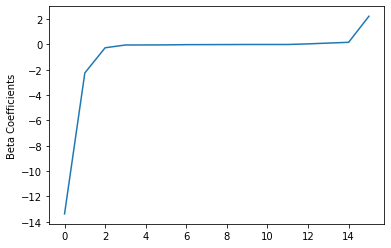

In [49]:
#надо дропнуть никто не шарит 
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(model_lr.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model over the training set, we can also obtain the ROC Receiver-Operating Characteristic) and the Area under ROC (areaUnderROC).

/usr/local/lib/python3.6/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


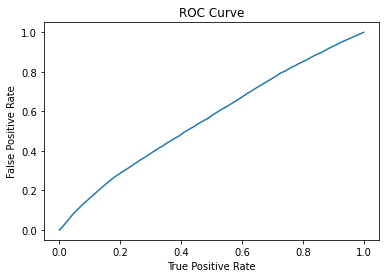

Training set areaUnderROC: 0.5624118088211697


In [50]:
trainingSummary = model_lr.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Precision and recall

/usr/local/lib/python3.6/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


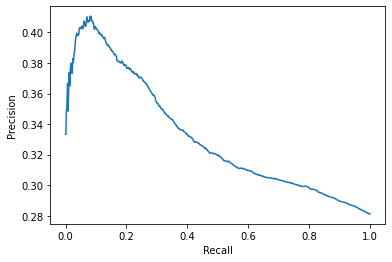

In [51]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [52]:
# from pyspark.ml.evaluation import BinaryClassificationEvaluator 

# lrEval = BinaryClassificationEvaluator()
# evaluator1_area_ROC = lrEval.evaluate(predictions)
# print('Area Under ROC on test data = {}'.format(evaluator1_area_ROC))

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator 

# Evaluate the performance of the model
lrEval = BinaryClassificationEvaluator(labelCol='label')
# evaluator2_area_ROC = lrEval.evaluate(predictions)
auroc = lrEval.evaluate(predictions,{lrEval.metricName:'areaUnderROC'})
aupr = lrEval.evaluate(predictions,{lrEval.metricName:'areaUnderPR'})

print(f"AUROC: {auroc}")
print(f"AUPR: {aupr}")

# Initialize the MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy, precision, recall, and F1 score
accuracy1 = evaluator1.evaluate(predictions, {evaluator1.metricName: "accuracy"})
precision1 = evaluator1.evaluate(predictions, {evaluator1.metricName: "weightedPrecision"})
recall1 = evaluator1.evaluate(predictions, {evaluator1.metricName: "weightedRecall"})
f11 = evaluator1.evaluate(predictions, {evaluator1.metricName: "f1"})

# Print the metrics

print(f"Accuracy: {accuracy1}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1 Score: {f11}")

AUROC: 0.5619864029594703
AUPR: 0.3347657812467057
Accuracy: 0.7186316049050597
Precision: 0.5163709924296376
Recall: 0.7186505267877158
F1 Score: 0.601030705494108


## Hyperparameter optimization

In [53]:
model_lr.params

[Param(parent='LogisticRegression_5ec06869222b', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_5ec06869222b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_5ec06869222b', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_5ec06869222b', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_5ec06869222b', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_5ec06869222b', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_5ec06869222b', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

In [54]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

import numpy as np


# grid = ParamGridBuilder()
# grid = grid.addGrid(
#                     model_lr.aggregationDepth, [2, 3, 4])\
#                     .addGrid(model_lr.regParam, np.logspace(1e-3,1e-1)
#                     )\
#                     .build()




# Создайте сетку параметров
paramGrid = ParamGridBuilder() \
    .addGrid(model_lr.regParam, [0.1, 0.01]) \
    .addGrid(model_lr.fitIntercept, [False, True]) \
    .addGrid(model_lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Создайте экземпляр CrossValidator
cv = CrossValidator(estimator = lr, 
                    estimatorParamMaps = paramGrid, 
                    evaluator = lrEval,
                    parallelism = 5,
                    numFolds=3)

# Обучите модель на тренировочных данных
cvModel = cv.fit(train_data)
bestModel = cvModel.bestModel
bestModel

# Предскажите на тестовых данных
# predictions = cvModel.transform(testData)

LogisticRegressionModel: uid=LogisticRegression_5ec06869222b, numClasses=2, numFeatures=16

## Best model 1


In [55]:
from pprint import pprint
model1 = bestModel
pprint(model1.extractParamMap())

{Param(parent='LogisticRegression_5ec06869222b', name='maxIter', doc='max number of iterations (>= 0).'): 100,
 Param(parent='LogisticRegression_5ec06869222b', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='LogisticRegression_5ec06869222b', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='LogisticRegression_5ec06869222b', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_5ec06869222b', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_5ec06869222b', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_5ec06869222b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha =

## Save the model to HDFS

In [56]:
model1.write().overwrite().save("project/models/model1")

# Run it from root directory of the repository
run("hdfs dfs -get project/models/model1 models/model1")

''

## Predict for test data using best model1

In [57]:
predictions = model1.transform(test_data)
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[0.51770134398803...|[0.62661010675338...|       0.0|
|    0|[97.0,404347.0,53...|[0.82312281021669...|[0.69489882366434...|       0.0|
|    0|[167.0,405490.0,6...|[0.59692313167349...|[0.64495205217612...|       0.0|
|    0|[303.0,359520.0,1...|[1.01965075380937...|[0.73490456495987...|       0.0|
|    0|[306.0,359520.0,1...|[0.94075545656655...|[0.71925223086123...|       0.0|
|    0|[306.0,359520.0,1...|[0.97350102469944...|[0.72581677600386...|       0.0|
|    0|[348.0,359520.0,1...|[1.05294018879355...|[0.74133909631765...|       0.0|
|    0|[413.0,405490.0,6...|[0.69791598514771...|[0.66772555740560...|       0.0|
|    0|[471.0,359520.0,1...|[0.97955490370998...|[0.72701989058129...|       0.0|
|    0|[625.0,41

In [58]:
predictions.select("label", "prediction")\
    .coalesce(1)\
    .write\
    .mode("overwrite")\
    .format("csv")\
    .option("sep", ",")\
    .option("header","true")\
    .save("project/output/model1_predictions.csv")

# Run it from root directory of the repository
run("hdfs dfs -cat project/output/model1_predictions.csv/*.csv > output/model1_predictions.csv")

''

## Evaluate the best model1

In [59]:
# from pyspark.ml.evaluation import RegressionEvaluator 

# # Evaluate the performance of the model
# evaluator1_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# evaluator1_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# rmse1 = evaluator1_rmse.evaluate(predictions)
# r21 = evaluator1_r2.evaluate(predictions)

# print("Root Mean Squared Error (RMSE) on test data = {}".format(rmse1))
# print("R^2 on test data = {}".format(r21))



from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluate the performance of the model
lrEval1 = BinaryClassificationEvaluator(labelCol='label')
# evaluator2_area_ROC = lrEval.evaluate(predictions)
auroc1 = lrEval1.evaluate(predictions,{lrEval1.metricName:'areaUnderROC'})
aupr1 = lrEval1.evaluate(predictions,{lrEval1.metricName:'areaUnderPR'})

print(f"AUROC: {auroc1}")
print(f"AUPR: {aupr1}")
# lrEval = BinaryClassificationEvaluator()
# evaluator1_area_ROC = lrEval.evaluate(predictions)
# print('Area Under ROC on test data = {}'.format(evaluator1_area_ROC))

# Initialize the MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy, precision, recall, and F1 score
accuracy1 = evaluator1.evaluate(predictions, {evaluator1.metricName: "accuracy"})
precision1 = evaluator1.evaluate(predictions, {evaluator1.metricName: "weightedPrecision"})
recall1 = evaluator1.evaluate(predictions, {evaluator1.metricName: "weightedRecall"})
f11 = evaluator1.evaluate(predictions, {evaluator1.metricName: "f1"})

# Print the metrics

print(f"Accuracy: {accuracy1}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1 Score: {f11}")

AUROC: 0.5616692640126489
AUPR: 0.3366785351503631
Accuracy: 0.7154670132664037
Precision: 0.510953934510016
Recall: 0.7140522875816994
F1 Score: 0.5956348854372476


# Second model

## Build a model

In [60]:
from pyspark.ml.classification import GBTClassifier

# Create Linear Regression Model
gbt = GBTClassifier()

# Fit the data to the pipeline stages
model_gbt = gbt.fit(train_data)


# from pyspark.ml.classification import GBTClassifier

# gbt = GBTClassifier()
# gbtModel = gbt.fit(train)
# gbtPreds = gbtModel.transform(test)

## Predict for test data

In [61]:
predictions = model_gbt.transform(test_data)
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[0.33345787942643...|[0.66081220238407...|       0.0|
|    0|[97.0,404347.0,53...|[0.37383831210757...|[0.67867223661098...|       0.0|
|    0|[167.0,405490.0,6...|[0.32833362748135...|[0.65851133662425...|       0.0|
|    0|[303.0,359520.0,1...|[0.64916979631029...|[0.78555540657611...|       0.0|
|    0|[306.0,359520.0,1...|[0.50065969407939...|[0.73131790699118...|       0.0|
|    0|[306.0,359520.0,1...|[0.56320581633122...|[0.75517607081943...|       0.0|
|    0|[348.0,359520.0,1...|[0.55965406930598...|[0.75386036071536...|       0.0|
|    0|[413.0,405490.0,6...|[0.36068761271520...|[0.67290977916791...|       0.0|
|    0|[471.0,359520.0,1...|[0.41823861380264...|[0.69772276110199...|       0.0|
|    0|[625.0,41

## Evaluate the model

In [62]:
# from pyspark.ml.evaluation import RegressionEvaluator 

# # Evaluate the performance of the model
# evaluator2_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# evaluator2_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# rmse2 = evaluator2_rmse.evaluate(predictions)
# r22 = evaluator2_r2.evaluate(predictions)

# print("Root Mean Squared Error (RMSE) on test data = {}".format(rmse2))
# print("R^2 on test data = {}".format(r22))

from pyspark.ml.evaluation import BinaryClassificationEvaluator 

# Evaluate the performance of the model
lrEval2 = BinaryClassificationEvaluator(labelCol='label')
# evaluator2_area_ROC = lrEval.evaluate(predictions)
auroc2 = lrEval2.evaluate(predictions,{lrEval2.metricName:'areaUnderROC'})
aupr2 = lrEval2.evaluate(predictions,{lrEval2.metricName:'areaUnderPR'})

print(f"AUROC: {auroc2}")
print(f"AUPR: {aupr2}")
# print('Area Under ROC on test data = {}'.format(evaluator2_area_ROC))


# Evaluate the model using a BinaryClassificationEvaluator
# evaluator = BinaryClassificationEvaluator(labelCol='label')
# auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
# aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

# Initialize the MulticlassClassificationEvaluator
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy, precision, recall, and F1 score
accuracy2 = evaluator2.evaluate(predictions, {evaluator2.metricName: "accuracy"})
precision2 = evaluator2.evaluate(predictions, {evaluator2.metricName: "weightedPrecision"})
recall2 = evaluator2.evaluate(predictions, {evaluator2.metricName: "weightedRecall"})
f12 = evaluator2.evaluate(predictions, {evaluator2.metricName: "f1"})

# Print the metrics

print(f"Accuracy: {accuracy2}")
print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1 Score: {f12}")

AUROC: 0.6042188717346797
AUPR: 0.37463442539067476
Accuracy: 0.7157446808510638
Precision: 0.7220698909262421
Recall: 0.7153157187639946
F1 Score: 0.5981149361326188


## Hyperparameter optimization

In [63]:
model_gbt.params

[Param(parent='GBTClassifier_d9204f445ad7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'),
 Param(parent='GBTClassifier_d9204f445ad7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'),
 Param(parent='GBTClassifier_d9204f445ad7', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression),

In [64]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

import numpy as np


grid = ParamGridBuilder()
grid = grid.addGrid(model_gbt.maxDepth, [2, 5, 10]).addGrid(model_gbt.maxBins, [20, 30]).build()

cv = CrossValidator(estimator = gbt, 
                    estimatorParamMaps = grid, 
                    evaluator = lrEval2,
                    parallelism = 5,
                    numFolds=3)

cvModel = cv.fit(train_data)
bestModel = cvModel.bestModel
bestModel

GBTClassificationModel: uid = GBTClassifier_d9204f445ad7, numTrees=20, numClasses=2, numFeatures=16

## Best model 2


In [65]:
from pprint import pprint
model2 = bestModel
pprint(model2.extractParamMap())

{Param(parent='GBTClassifier_d9204f445ad7', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1,
 Param(parent='GBTClassifier_d9204f445ad7', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0,
 Param(parent='GBTClassifier_d9204f445ad7', name='validationTol', doc='Threshold for stopping early when fit with validation is used. If the error rate on the validation input changes by less than the validationTol, then learning will stop early (before `maxIter`). This parameter is ignored when fit without validation is used.'): 0.01,
 Param(parent='GBTClassifier_d9204f445ad7', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic'): 'logistic',
 Param(parent='GBTClassifier_d9204f445ad7', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='GBTClassifier_d9204f445ad7',

## Save the model to HDFS

In [66]:
model2.write().overwrite().save("project/models/model2")

# Run it from root directory of the repository
run("hdfs dfs -get project/models/model2 models/model2")

''

## Predict for test data using best model2

In [67]:
predictions = model2.transform(test_data)
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[0.44727771828679...|[0.70982935941881...|       0.0|
|    0|[97.0,404347.0,53...|[1.10380079115408...|[0.90093006160002...|       0.0|
|    0|[167.0,405490.0,6...|[-0.9722317562793...|[0.12515831172152...|       1.0|
|    0|[303.0,359520.0,1...|[0.34127913692909...|[0.66430943823514...|       0.0|
|    0|[306.0,359520.0,1...|[0.12339034798927...|[0.56138396248941...|       0.0|
|    0|[306.0,359520.0,1...|[0.12339034798927...|[0.56138396248941...|       0.0|
|    0|[348.0,359520.0,1...|[0.64140142224086...|[0.78292650484321...|       0.0|
|    0|[413.0,405490.0,6...|[-0.0112128380839...|[0.49439381590700...|       1.0|
|    0|[471.0,359520.0,1...|[0.47384230716692...|[0.72064929695404...|       0.0|
|    0|[625.0,41

In [68]:
predictions.select("label", "prediction")\
    .coalesce(1)\
    .write\
    .mode("overwrite")\
    .format("csv")\
    .option("sep", ",")\
    .option("header","true")\
    .save("project/output/model2_predictions.csv")

# Run it from root directory of the repository
run("hdfs dfs -cat project/output/model2_predictions.csv/*.csv > output/model2_predictions.csv")

''

## Evaluate the best model2

In [69]:
# from pyspark.ml.evaluation import RegressionEvaluator 

# # Evaluate the performance of the model
# evaluator2_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# evaluator2_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# rmse2 = evaluator2_rmse.evaluate(predictions)
# r22 = evaluator2_r2.evaluate(predictions)

# print("Root Mean Squared Error (RMSE) on test data = {}".format(rmse2))
# print("R^2 on test data = {}".format(r22))

from pyspark.ml.evaluation import BinaryClassificationEvaluator 

# Evaluate the performance of the model
lrEval2 = BinaryClassificationEvaluator(labelCol='label')
# evaluator2_area_ROC = lrEval.evaluate(predictions)
auroc2 = lrEval2.evaluate(predictions,{lrEval2.metricName:'areaUnderROC'})
aupr2 = lrEval2.evaluate(predictions,{lrEval2.metricName:'areaUnderPR'})
# print('Area Under ROC on test data = {}'.format(evaluator2_area_ROC))


# Evaluate the model using a BinaryClassificationEvaluator
# evaluator = BinaryClassificationEvaluator(labelCol='label')
# auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
# aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

print(f"AUROC: {auroc2}")
print(f"AUPR: {aupr2}")

# Initialize the MulticlassClassificationEvaluator
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy, precision, recall, and F1 score
accuracy2 = evaluator2.evaluate(predictions, {evaluator2.metricName: "accuracy"})
precision2 = evaluator2.evaluate(predictions, {evaluator2.metricName: "weightedPrecision"})
recall2 = evaluator2.evaluate(predictions, {evaluator2.metricName: "weightedRecall"})
f12 = evaluator2.evaluate(predictions, {evaluator2.metricName: "f1"})

# Print the metrics

print(f"Accuracy: {accuracy2}")
print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1 Score: {f12}")

AUROC: 0.7136355105679135
AUPR: 0.5027309800770258
Accuracy: 0.7364096363962027
Precision: 0.7268725045237213
Recall: 0.7368362138443628
F1 Score: 0.6711229603457609


# Third Model

## Model training

In [70]:
# from pyspark.ml.regression import LinearRegression
# # Create Linear Regression Model
# lr = LinearRegression()

# # Fit the data to the lr model
# model_lr = lr.fit(train_data)

from pyspark.ml.classification import RandomForestClassifier
# Create Random Forest Model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# Fit the data to the rf model
rfModel = rf.fit(train_data)

## Prediction

In [71]:
# Transform the data (Prediction)
# predictions = model_lr.transform(testData)
predictions = rfModel.transform(test_data)
# Display the predictions
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[13.9283537759930...|[0.69641768879965...|       0.0|
|    0|[97.0,404347.0,53...|[13.8337368023069...|[0.69168684011534...|       0.0|
|    0|[167.0,405490.0,6...|[13.4687274325752...|[0.67343637162876...|       0.0|
|    0|[303.0,359520.0,1...|[14.7438211495448...|[0.73719105747724...|       0.0|
|    0|[306.0,359520.0,1...|[14.5096966667687...|[0.72548483333843...|       0.0|
|    0|[306.0,359520.0,1...|[14.7438211495448...|[0.73719105747724...|       0.0|
|    0|[348.0,359520.0,1...|[14.8069061303024...|[0.74034530651512...|       0.0|
|    0|[413.0,405490.0,6...|[13.5560268066387...|[0.67780134033193...|       0.0|
|    0|[471.0,359520.0,1...|[14.7578410806907...|[0.73789205403453...|       0.0|
|    0|[625.0,41

## Evaluation

In [72]:
# from pyspark.ml.evaluation import RegressionEvaluator 

# # Evaluate the performance of the model
# evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

from pyspark.ml.evaluation import BinaryClassificationEvaluator 

# Evaluate the performance of the model
lrEval3 = BinaryClassificationEvaluator(labelCol='label')
# evaluator2_area_ROC = lrEval.evaluate(predictions)
auroc3 = lrEval3.evaluate(predictions,{lrEval3.metricName:'areaUnderROC'})
aupr3 = lrEval3.evaluate(predictions,{lrEval3.metricName:'areaUnderPR'})

print(f"AUROC: {auroc3}")
print(f"AUPR: {aupr3}")
# Initialize the MulticlassClassificationEvaluator
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy, precision, recall, and F1 score
accuracy3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "accuracy"})
precision3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "weightedPrecision"})
recall3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "weightedRecall"})
f13 = evaluator3.evaluate(predictions, {evaluator3.metricName: "f1"})

# Print the metrics

print(f"Accuracy: {accuracy3}")
print(f"Precision: {precision3}")
print(f"Recall: {recall3}")
print(f"F1 Score: {f13}")

AUROC: 0.572481848359309
AUPR: 0.3506218728060597


In [73]:
# !pip install sklearn

In [75]:
# # Initialize the MulticlassClassificationEvaluator
# evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# # Compute accuracy, precision, recall, and F1 score
# accuracy3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "accuracy"})
# precision3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "weightedPrecision"})
# recall3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "weightedRecall"})
# f13 = evaluator3.evaluate(predictions, {evaluator3.metricName: "f1"})

# # Print the metrics

# print(f"Accuracy: {accuracy3}")
# print(f"Precision: {precision3}")
# print(f"Recall: {recall3}")
# print(f"F1 Score: {f13}")

Accuracy: 0.7186316049050597
Precision: 0.5163306748901161
Recall: 0.7186316049050597
F1 Score: 0.6000666638331869


In [97]:
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[14.3849576497880...|[0.47949858832626...|       1.0|
|    0|[37.0,405490.0,60...|[15.6937703469672...|[0.52312567823224...|       0.0|
|    0|[101.0,414149.0,4...|[24.1894106488667...|[0.80631368829555...|       0.0|
|    0|[109.0,359520.0,1...|[24.1223942357805...|[0.80407980785935...|       0.0|
|    0|[142.0,405490.0,6...|[21.6344130185630...|[0.72114710061876...|       0.0|
|    0|[221.0,360936.0,1...|[24.0263271832446...|[0.80087757277482...|       0.0|
|    0|[306.0,359520.0,1...|[20.6827450586369...|[0.68942483528789...|       0.0|
|    0|[306.0,359520.0,1...|[21.9223560638765...|[0.73074520212921...|       0.0|
|    0|[306.0,359520.0,1...|[26.2855018943796...|[0.87618339647932...|       0.0|
|    0|[375.0,35

In [101]:
print(predictions.toPandas().head(20))

    label                                           features  \
0       0  [37.0, 404347.0, 53587.0, 1.0, 1.0, 0.39435585...   
1       0  [37.0, 405490.0, 60305.0, 3.0, 1.0, 0.72479278...   
2       0  [101.0, 414149.0, 45962.0, 2.0, 0.0, 0.5712682...   
3       0  [109.0, 359520.0, 13787.0, 4.0, 1.0, 0.7247927...   
4       0  [142.0, 405490.0, 60305.0, 3.0, 0.0, 0.5712682...   
5       0  [221.0, 360936.0, 13787.0, 5.0, 1.0, 0.5712682...   
6       0  [306.0, 359520.0, 13787.0, 3.0, 1.0, 0.3943558...   
7       0  [306.0, 359520.0, 13787.0, 4.0, 1.0, 0.3943558...   
8       0  [306.0, 359520.0, 13787.0, 4.0, 1.0, 0.5712682...   
9       0  [375.0, 359520.0, 13787.0, 4.0, 0.0, 0.5712682...   
10      0  [397.0, 82320.0, 1734.0, 1.0, 0.0, 0.571268215...   
11      0  [413.0, 405490.0, 60305.0, 3.0, 0.0, 0.3943558...   
12      0  [577.0, 359520.0, 13787.0, 2.0, 0.0, 0.7247927...   
13      0  [601.0, 405490.0, 60305.0, 3.0, 0.0, 0.7247927...   
14      0  [613.0, 359520.0, 13787.0, 3.

In [95]:
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import confusion_matrix

# Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
# Meaning 0 1 in columns. Rows also 0 then 1.

# Evaluate using MultiClass Metrics
pred_rdd = predictions.select('prediction','label').rdd.map(tuple)
metrics = MulticlassMetrics(pred_rdd)


print(metrics.confusionMatrix())

confusion_matrix = metrics.confusionMatrix().toArray()
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
# Add actual values to the cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Py4JJavaError: An error occurred while calling o24289.confusionMatrix.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11831.0 failed 4 times, most recent failure: Lost task 0.3 in stage 11831.0 (TID 1440129) (hadoop-02.uni.innopolis.ru executor 64): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/session.py", line 682, in prepare
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1411, in verify
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1392, in verify_struct
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1411, in verify
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1405, in verify_default
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1294, in verify_acceptable_types
TypeError: field label: DoubleType can not accept object 0 in type <class 'int'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2450)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2399)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2398)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2398)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1156)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2638)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2580)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2569)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2224)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2245)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2264)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2289)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:737)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:736)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels$lzycompute(MulticlassMetrics.scala:241)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels(MulticlassMetrics.scala:241)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusionMatrix(MulticlassMetrics.scala:113)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/srv/hadoop-yarn/nm-local/usercache/team9/appcache/application_1715165960394_0237/container_e31_1715165960394_0237_01_000077/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/session.py", line 682, in prepare
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1411, in verify
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1392, in verify_struct
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1411, in verify
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1405, in verify_default
  File "/usr/local/lib/python3.6/site-packages/pyspark/sql/types.py", line 1294, in verify_acceptable_types
TypeError: field label: DoubleType can not accept object 0 in type <class 'int'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
# from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# from pyspark.mllib.evaluation import MulticlassMetrics

# from sklearn.metrics import confusion_matrix

# # Evaluate using MultiClass Metrics
# pred_rdd = predictions.select('prediction','label').rdd.map(tuple)
# metrics = MulticlassMetrics(pred_rdd)
# accuracy_o = metrics.accuracy   # Positive class
# precision_o = metrics.precision(1.0)  # Positive class
# recall_o = metrics.recall(1.0)  # Positive class
# f1_o = metrics.fMeasure(1.0)  # Positive class

# print("Accuracy:", accuracy_o)
# print("Precision:", precision_o)
# print("Recall:", recall_o)
# print("F1-score:", f1_o)

## Hyperparameter optimization

In [79]:
rfModel.params

[Param(parent='RandomForestClassifier_94bc541f4c90', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'),
 Param(parent='RandomForestClassifier_94bc541f4c90', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'),
 Param(parent='RandomForestClassifier_94bc541f4c90', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'),
 Param(parent='RandomForestClassifier_94bc541f4c90', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'a

In [83]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

import numpy as np


grid = ParamGridBuilder()
# grid = grid.addGrid(
#                     model_lr.aggregationDepth, [2, 3, 4])\
#                     .addGrid(model_lr.regParam, np.logspace(1e-3,1e-1)
#                     )\
#                     .build()

# paramGrid = ParamGridBuilder() \
grid = grid.addGrid(rfModel.numTrees, [10, 20, 30]) \
    .addGrid(rfModel.maxDepth, [5, 10, 15])\
    .build()

cv = CrossValidator(estimator = rf, 
                    estimatorParamMaps = grid, 
                    evaluator = lrEval3,
                    parallelism = 5,
                    numFolds=3)

cvModel = cv.fit(train_data)
bestModel = cvModel.bestModel
bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_94bc541f4c90, numTrees=30, numClasses=2, numFeatures=16

## Select best model

In [84]:
from pprint import pprint
model3 = bestModel
pprint(model3.extractParamMap())

{Param(parent='RandomForestClassifier_94bc541f4c90', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='RandomForestClassifier_94bc541f4c90', name='minWeightFractionPerNode', doc='Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5).'): 0.0,
 Param(parent='RandomForestClassifier_94bc541f4c90', name='seed', doc='random seed.'): 5361263949622253908,
 Param(parent='RandomForestClassifier_94bc541f4c90', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='RandomForestClassifier_94bc541f4c90', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treat

## Save the model to HDFS

In [85]:
model3.write().overwrite().save("project/models/model3")

# Run it from root directory of the repository
run("hdfs dfs -get project/models/model3 models/model3")

''

## Prediction

In [86]:
predictions = model3.transform(test_data)
predictions.show()

predictions.select("label", "prediction")\
    .coalesce(1)\
    .write\
    .mode("overwrite")\
    .format("csv")\
    .option("sep", ",")\
    .option("header","true")\
    .save("project/output/model3_predictions.csv")

# Run it from root directory of the repository
run("hdfs dfs -cat project/output/model3_predictions.csv/*.csv > output/model3_predictions.csv")

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[37.0,404347.0,53...|[14.3849576497880...|[0.47949858832626...|       1.0|
|    0|[97.0,404347.0,53...|[20.2942417074539...|[0.67647472358179...|       0.0|
|    0|[167.0,405490.0,6...|[17.6595623868778...|[0.58865207956259...|       0.0|
|    0|[303.0,359520.0,1...|[19.9472035134890...|[0.66490678378296...|       0.0|
|    0|[306.0,359520.0,1...|[20.6827450586369...|[0.68942483528789...|       0.0|
|    0|[306.0,359520.0,1...|[17.2005983801011...|[0.57335327933670...|       0.0|
|    0|[348.0,359520.0,1...|[19.9540975236039...|[0.66513658412013...|       0.0|
|    0|[413.0,405490.0,6...|[15.5086369939249...|[0.51695456646416...|       0.0|
|    0|[471.0,359520.0,1...|[23.1991449768603...|[0.77330483256201...|       0.0|
|    0|[625.0,41

''

## Evaluation

In [91]:
# from pyspark.ml.evaluation import RegressionEvaluator 

# # Evaluate the performance of the model
# evaluator1 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# rmse1 = evaluator1.evaluate(predictions)
# print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

from pyspark.ml.evaluation import BinaryClassificationEvaluator 

# Evaluate the performance of the model
lrEval3 = BinaryClassificationEvaluator(labelCol='label')
# evaluator2_area_ROC = lrEval.evaluate(predictions)
auroc3 = lrEval3.evaluate(predictions,{lrEval3.metricName:'areaUnderROC'})
aupr3 = lrEval3.evaluate(predictions,{lrEval3.metricName:'areaUnderPR'})

print(f"AUROC: {auroc3}")
print(f"AUPR: {aupr3}")

# Initialize the MulticlassClassificationEvaluator
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy, precision, recall, and F1 score
accuracy3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "accuracy"})
precision3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "weightedPrecision"})
recall3 = evaluator3.evaluate(predictions, {evaluator3.metricName: "weightedRecall"})
f13 = evaluator3.evaluate(predictions, {evaluator3.metricName: "f1"})

# Print the metrics

print(f"Accuracy: {accuracy3}")
print(f"Precision: {precision3}")
print(f"Recall: {recall3}")
print(f"F1 Score: {f13}")

AUROC: 0.7943144427681609
AUPR: 0.6445832585486191
Accuracy: 0.7499888058030717
Precision: 0.7865741097367034
Recall: 0.7367313118645585
F1 Score: 0.6737646133508346


# Compare best models

In [92]:
models = [[str(model1),auroc1, aupr1, f11], [str(model2),auroc2, aupr2, f12], [str(model3),auroc3, aupr3, f13]]

df = spark.createDataFrame(models, ["model", "AUROC", "AUPR", "F1"])
df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------+------------------+------------------+------------------+
|model                                                                                                              |AUROC             |AUPR              |F1                |
+-------------------------------------------------------------------------------------------------------------------+------------------+------------------+------------------+
|LogisticRegressionModel: uid=LogisticRegression_5ec06869222b, numClasses=2, numFeatures=16                         |0.5616692640126489|0.3366785351503631|0.5956348854372476|
|GBTClassificationModel: uid = GBTClassifier_d9204f445ad7, numTrees=20, numClasses=2, numFeatures=16                |0.7136355105679135|0.5027309800770258|0.6711229603457609|
|RandomForestClassificationModel: uid=RandomForestClassifier_94bc541f4c90, numTrees=30, numClasses=2, numFeatures=16|0.794314

In [ ]:
df.coalesce(1)\
    .write\
    .mode("overwrite")\
    .format("csv")\
    .option("sep", ",")\
    .option("header","true")\
    .save("project/output/evaluation.csv")

# Run it from root directory of the repository
run("hdfs dfs -cat project/output/evaluation.csv/*.csv > output/evaluation.csv")

In [ ]:
run("hdfs dfs -cat project/output/hyperparametrs_1.csv/*.csv > output/hyperparametrs_1.csv")
# project/BigData/output/hyperparametrs_3.csv'

In [ ]:
run("hdfs dfs -cat project/output/hyperparametrs_2.csv/*.csv > output/hyperparametrs_2.csv")
run("hdfs dfs -cat project/output/hyperparametrs_3.csv/*.csv > output/hyperparametrs_3.csv")